iter=1: norm=0.0967457
iter=2: norm=0.0250205
iter=3: norm=0.0158139
iter=4: norm=0.0101398
iter=5: norm=0.00741008
iter=6: norm=0.00579682
iter=7: norm=0.00456457
iter=8: norm=0.00363871
iter=9: norm=0.00293372
iter=10: norm=0.0025233
iter=11: norm=0.00219047
iter=12: norm=0.00191637
iter=13: norm=0.00168747
iter=14: norm=0.00149397
iter=15: norm=0.00132861
iter=16: norm=0.00121154
iter=17: norm=0.00110993
iter=18: norm=0.00101857
iter=19: norm=0.000936313
iter=20: norm=0.000862159
iter=21: norm=0.00079521
iter=22: norm=0.000746481
iter=23: norm=0.000705558
iter=24: norm=0.000666482
iter=25: norm=0.000629326
iter=26: norm=0.000594109
iter=27: norm=0.00056081
iter=28: norm=0.000529382
iter=29: norm=0.000503923
iter=30: norm=0.000481718
iter=31: norm=0.000460857
iter=32: norm=0.00044361
iter=33: norm=0.000428994
iter=34: norm=0.000414729
iter=35: norm=0.00040083
iter=36: norm=0.000387311
iter=37: norm=0.000374179
iter=38: norm=0.000361438
iter=39: norm=0.000349089
iter=40: norm=0.000337

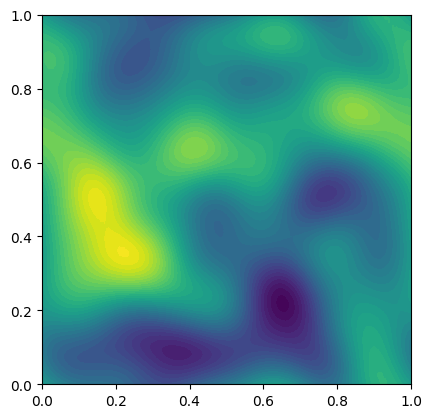

In [1]:
from dolfin import *
import numpy as np
from numpy.random import random


# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        # return True if on left or bottom boundary AND NOT on one of the two corners (0, 1) and (1, 0)
        return bool((near(x[0], 0) or near(x[1], 0)) and \
                (not ((near(x[0], 0) and near(x[1], 1)) or \
                        (near(x[0], 1) and near(x[1], 0)))) and on_boundary)





    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        if near(x[0], 1) and near(x[1], 1):
            y[0] = x[0] - 1.
            y[1] = x[1] - 1.
        elif near(x[0], 1):
            y[0] = x[0] - 1.
            y[1] = x[1]
        else:   # near(x[1], 1)
            y[0] = x[0]
            y[1] = x[1] - 1.

#Initial condtions (Random)
class IC(UserExpression):
    def eval(self,values,x):
        values[0] = 0.1*random() -0.1*random()
        values[1] = 0.1*random() -0.1*random()
    def value_shape(self):
        return(2,)


#Parameters
dt = 5.0e-06

G = Constant(0.9)
A = Constant(6.0)
B = Constant(4.0)
d = Constant(20.0)

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True
#parameters["form_compiler"]["representation"] = "quadrature"

# Create mesh and finite element
mesh = UnitSquareMesh(100, 100)
P1 = FiniteElement("P", triangle, 1)
element = MixedElement([P1, P1])
V = FunctionSpace(mesh, element, constrained_domain=PeriodicBoundary())
plot(mesh)



# Define variational problem
(u_1, u_2) = TrialFunctions(V)
(v_1, v_2) = TestFunctions(V)

u_=Function(V) #new solution, time: n
u_1_,u_2_=split(u_)
u_n =Function(V) #old solution, time: n-1
u_n1, u_n2 =split(u_n)

u1init = IC(element = u_n.ufl_element())
u_n.interpolate(u1init)

def ff(u_n1,u_n2):
    return u_n1-A*u_n2+G*u_n1*u_n2-u_n1**3

def gg(u_n1,u_n2):
    return u_n1-B*u_n2


F =   inner(u_1,v_1)/dt*dx \
    + inner(u_2,v_2)/dt*dx \
    + inner(grad(u_1), grad(v_1))*dx \
    + d*inner(grad(u_2), grad(v_2))*dx \
    -(inner(u_n1,v_1)/dt + inner(u_n2,v_2)/dt)*dx \
    -(inner(ff(u_n1,u_n2),v_1) + inner(gg(u_n1,u_n2),v_2))*dx 
      
a1=lhs(F)
L1=rhs(F)
A1=assemble(a1)

t = 0.0
T=600*dt
vtkfile_u_1 = File("Turing_new/u_1.pvd","compressed")
vtkfile_u_2 = File("Turing_new/u_2.pvd","compressed")
i=0
while (t<T):
# Update current time
    i +=1
    t += dt
    b1=assemble(L1)
    solve(A1,u_.vector(),b1,"lu")
# Save solution to file (VTK)
    
    diff = u_.vector() - u_n.vector() 
    eps = np.linalg.norm(diff, ord=np.Inf) #infinity norm
    print ("iter=%d: norm=%g" % (i, eps))
    u_n.assign(u_) # update for next iteration
    _u_1, _u_2 = u_n.split()
    vtkfile_u_1 << (_u_1, t)
    vtkfile_u_2 << (_u_2, t)
#plot the solution
plot(u_n1)
